# 第5章：在无标签数据上进行预训练

In [1]:
from importlib.metadata import version

pkgs = ["matplotlib", 
        "numpy", 
        "tiktoken", 
        "torch",
        "tensorflow" # For OpenAI's pretrained weights
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.8
numpy version: 2.0.2
tiktoken version: 0.12.0
torch version: 2.9.1
tensorflow version: 2.20.0


- 在本章中，我们实现训练循环和基本模型评估代码来预训练一个 LLM
- 在本章末尾，我们还将从 OpenAI 加载公开可用的预训练权重到我们的模型中

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/chapter-overview.webp" width=500px>

- 本章涵盖的主题如下所示

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/mental-model--0.webp" width=400px>

## 5.1 评估生成式文本模型

- 我们首先简要回顾如何使用前一章的代码初始化 GPT 模型
- 然后，我们讨论 LLM 的基本评估指标
- 最后，在本节中，我们将这些评估指标应用到训练集和验证集上

### 5.1.1 使用 GPT 生成文本

- 我们使用前一章的代码初始化 GPT 模型

In [ ]:
# 导入PyTorch核心库：提供张量计算和自动微分功能
# torch是PyTorch的主要模块，包含所有核心功能，如张量操作、神经网络层、优化器等
import torch

# 从previous_chapters模块导入GPTModel类：这是在前一章中实现的完整GPT模型
# GPTModel是Generative Pre-trained Transformer模型的完整实现，包含嵌入层、transformer块和输出层
from previous_chapters import GPTModel
# 如果本地没有`previous_chapters.py`文件，
# 可以从`llms-from-scratch` PyPI包中导入
# 详细信息请参见: https://github.com/rasbt/LLMs-from-scratch/tree/main/pkg
# 例如：
# from llms_from_scratch.ch04 import GPTModel

# 定义GPT-2 124M参数模型的配置字典：包含模型的所有超参数
# 这个配置对应GPT-2 small模型，大约有1.24亿个参数
GPT_CONFIG_124M = {
    # 词汇表大小：50257是GPT-2使用的词汇表大小
    # 词汇表包含所有可能的token（单词片段、标点符号等），每个token对应一个唯一的整数ID
    # 这个数字来自GPT-2的BPE（字节对编码）分词器的词汇表大小
    "vocab_size": 50257,   # 词汇表大小
    
    # 上下文长度：模型能处理的最大token序列长度
    # 这里设置为256是为了减少计算资源需求（原始GPT-2使用1024）
    # 上下文长度决定了模型能看到多少历史token，影响模型的记忆能力
    "context_length": 256, # 缩短的上下文长度（原始值：1024）
    
    # 嵌入维度：每个token被转换为768维的向量表示
    # 这个维度决定了模型内部表示的空间大小，影响模型的表达能力
    # 768是GPT-2 small使用的嵌入维度
    "emb_dim": 768,        # 嵌入维度
    
    # 注意力头数量：多头注意力机制中的头数
    # 每个头关注不同的表示子空间，12个头允许模型同时关注多个方面
    # 多头机制使模型能够并行处理不同类型的信息
    "n_heads": 12,         # 注意力头数量
    
    # Transformer层数：模型包含的transformer块的数量
    # 每个transformer块包含自注意力机制和前馈网络
    # 12层是GPT-2 small的配置，更深的网络可以学习更复杂的模式
    "n_layers": 12,        # 层数
    
    # Dropout率：训练时随机置零的神经元比例
    # 0.1表示10%的神经元在训练时会被随机置零，用于防止过拟合
    # 注意：现代LLM训练通常不使用dropout，但这里保留以匹配某些配置
    "drop_rate": 0.1,      # Dropout率
    
    # 查询-键-值偏置：是否在注意力机制的Q、K、V线性变换中使用偏置项
    # False表示不使用偏置，这是现代LLM（如GPT-2）的设计选择
    # 不使用偏置可以稍微减少参数数量，并且通常不会影响性能
    "qkv_bias": False      # 查询-键-值偏置
}

# 设置随机种子：确保模型初始化的可重复性
# 123是种子值，相同的种子会产生相同的随机数序列
# 这对于实验的可重复性很重要，确保每次运行代码时模型权重初始化相同
torch.manual_seed(123)

# 创建GPT模型实例：使用配置字典初始化模型
# GPTModel(GPT_CONFIG_124M)：根据配置创建模型，包括：
#   - Token嵌入层：将token ID转换为768维向量
#   - 位置嵌入层：为每个位置分配768维向量
#   - 12个Transformer块：每个包含多头注意力和前馈网络
#   - 最终层归一化：在输出前对特征进行归一化
#   - 输出头：将内部表示转换为词汇表上的logits
# 模型总参数约为1.24亿个
model = GPTModel(GPT_CONFIG_124M)

# 将模型设置为评估模式：禁用dropout和批归一化的训练行为
# model.eval()：切换到推理模式，此时：
#   - Dropout层不会随机置零神经元（所有神经元都参与计算）
#   - 批归一化使用运行时的均值和方差，而不是当前批次的统计量
# 这对于模型推理和评估是必要的，确保结果的一致性
# 注意：分号(;)只是Python的语句分隔符，这里用于在同一行结束语句
model.eval();  # 在推理时禁用dropout

- 我们在上面使用了 0.1 的 dropout，但如今训练 LLM 时通常不使用 dropout
- 现代 LLM 在查询、键和值矩阵的 `nn.Linear` 层中也不使用偏置向量（与早期 GPT 模型不同），这是通过设置 `"qkv_bias": False` 来实现的
- 我们将上下文长度（`context_length`）减少到只有 256 个 token，以降低训练模型的计算资源需求，而原始的 1.24 亿参数 GPT-2 模型使用了 1024 个 token
  - 这样可以让更多读者能够在他们的笔记本电脑上运行和执行代码示例
  - 但是，请随时将 `context_length` 增加到 1024 个 token（这不需要任何代码更改）
  - 我们稍后也会从预训练权重加载一个 `context_length` 为 1024 的模型

- 接下来，我们使用前一章的 `generate_text_simple` 函数生成文本
- 此外，我们定义两个便利函数 `text_to_token_ids` 和 `token_ids_to_text`，用于在本章中使用的 token 和文本表示之间的转换

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/gpt-process.webp" width=500px>

In [3]:
import tiktoken
from previous_chapters import generate_text_simple

# Alternatively:
# from llms_from_scratch.ch04 import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


- 正如我们在上面看到的，模型还没有产生好的文本，因为它还没有被训练
- 我们如何以数字形式衡量或捕捉"好文本"是什么，以便在训练过程中跟踪它？
- 下一小节介绍用于计算生成输出损失指标的指标，我们可以用它来衡量训练进度
- 关于微调 LLM 的后续章节还将介绍衡量模型质量的额外方法

<br>

### 5.1.2 计算文本生成损失：交叉熵和困惑度

- 假设我们有一个包含 2 个训练样本（行）的 token ID 的 `inputs` 张量
- 与 `inputs` 相对应，`targets` 包含我们希望模型生成的期望 token ID
- 注意 `targets` 是 `inputs` 向右移动 1 个位置的结果，正如我们在第 2 章实现数据加载器时解释的那样

In [4]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

- 将 `inputs` 输入模型，我们得到 2 个输入样本的 logits 向量，每个样本由 3 个 token 组成
- 每个 token 是一个 50,257 维的向量，对应于词汇表的大小
- 应用 softmax 函数，我们可以将 logits 张量转换为相同维度的包含概率分数的张量 

In [5]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape) # Shape: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


- 下面的图使用一个非常小的词汇表来说明，概述了我们如何将概率分数转换回文本，这是我们在前一章末尾讨论的内容

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/proba-to-text.webp" width=500px>

- 正如前一章所讨论的，我们可以应用 `argmax` 函数将概率分数转换为预测的 token ID
- 上面的 softmax 函数为每个 token 生成了一个 50,257 维的向量；`argmax` 函数返回该向量中最高概率分数的位置，这是给定 token 的预测 token ID

- 由于我们有 2 个输入批次，每个批次有 3 个 token，我们得到 2×3 的预测 token ID：

In [6]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


- 如果我们解码这些 token，我们会发现它们与我们希望模型预测的 token（即目标 token）有很大不同：

In [7]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


- 这是因为模型还没有被训练
- 为了训练模型，我们需要知道它与正确预测（目标）的距离有多远

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/proba-index.webp" width=500px>

- 对应于目标索引的 token 概率如下：

In [8]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


- 我们希望最大化所有这些值，使它们接近概率 1
- 在数学优化中，最大化概率分数的对数比最大化概率分数本身更容易；这超出了本书的范围，但我在 [L8.2 逻辑回归损失函数](https://www.youtube.com/watch?v=GxJe0DZvydM) 中录制了更详细的讲座

In [9]:
# Compute logarithm of all token probabilities
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


- 接下来，我们计算平均对数概率：

In [10]:
# Calculate the average probability for each token
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


- 目标是通过优化模型权重使这个平均对数概率尽可能大
- 由于对数函数，最大可能值是 0，而我们目前距离 0 还很远

- 在深度学习中，不是最大化平均对数概率，而是最小化*负*平均对数概率值是标准约定；在我们的例子中，不是最大化 -10.7722 使其接近 0，在深度学习中，我们会最小化 10.7722 使其接近 0
- -10.7722 的负值，即 10.7722，在深度学习中也被称为交叉熵损失

In [11]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


- PyTorch 已经实现了一个 `cross_entropy` 函数来执行前面的步骤

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/cross-entropy.webp?123" width=400px>

- 在应用 `cross_entropy` 函数之前，让我们检查 logits 和 targets 的形状

In [12]:
# Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


- 对于 PyTorch 中的 `cross_entropy` 函数，我们希望通过在批次维度上组合来展平这些张量：

In [58]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)
print("Targets:", targets_flat)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])
Targets: tensor([ 3626,  6100,   345,  1107,   588, 11311])


- 注意 targets 是 token ID，它们也代表我们希望最大化的 logits 张量中的索引位置
- PyTorch 中的 `cross_entropy` 函数会自动处理在需要最大化的 logits 中的那些 token 索引上应用 softmax 和对数概率计算 

In [14]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


- 与交叉熵损失相关的一个概念是 LLM 的困惑度
- 困惑度就是交叉熵损失的指数

In [15]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


- 困惑度通常被认为更容易解释，因为它可以被理解为模型在每一步不确定的有效词汇表大小（在上面的例子中，这将是 48,725 个单词或 token）
- 换句话说，困惑度提供了模型预测的概率分布与数据集中单词的实际分布匹配程度的度量
- 与损失类似，较低的困惑度表明模型预测更接近实际分布

### 5.1.3 计算训练集和验证集损失

- 我们使用一个相对较小的数据集来训练 LLM（实际上，只有一个短篇故事）
- 原因如下：
  - 您可以在没有合适 GPU 的笔记本电脑上在几分钟内运行代码示例
  - 训练完成相对较快（几分钟而不是几周），这对教育目的很有好处
  - 我们使用公共领域的文本，可以包含在这个 GitHub 仓库中，而不会违反任何使用权利或使仓库大小膨胀


- 例如，Llama 2 7B 需要在 A100 GPU 上使用 184,320 GPU 小时来训练 2 万亿个 token
  - 在撰写本文时，AWS 上 8xA100 云服务器的每小时成本约为 \$30
  - 因此，通过粗略计算，训练这个 LLM 将花费 184,320 / 8 * \$30 = \$690,000
 
- 下面，我们使用第 2 章中使用的相同数据集


In [16]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

- 通过打印前 99 个和后 99 个字符来快速检查文本是否加载成功

In [17]:
# First 99 characters
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [18]:
# Last 99 characters
print(text_data[-99:])

it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [19]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


- 有 5,145 个 token，这个文本对于训练 LLM 来说非常短，但再次强调，这是为了教育目的（我们稍后也会加载预训练权重）

- 接下来，我们将数据集分为训练集和验证集，并使用第 2 章的数据加载器为 LLM 训练准备批次
- 为了可视化目的，下图假设 `max_length=6`，但对于训练加载器，我们将 `max_length` 设置为 LLM 支持的上下文长度
- 下图仅显示输入 token 以简化说明
    - 由于我们训练 LLM 来预测文本中的下一个单词，目标看起来与这些输入相同，只是目标向右移动了一个位置

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/batching.webp" width=500px>

In [20]:
from previous_chapters import create_dataloader_v1
# Alternatively:
# from llms_from_scratch.ch02 import create_dataloader_v1

# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [21]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

- 我们使用相对较小的批次大小来减少计算资源需求，并且因为数据集本身非常小
- 例如，Llama 2 7B 使用 1024 的批次大小进行训练

- 可选检查：数据是否正确加载：

In [22]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


- 另一个可选检查：token 大小是否在预期范围内：

In [23]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


- 接下来，我们实现一个实用函数来计算给定批次的交叉熵损失
- 此外，我们实现第二个实用函数来计算数据加载器中用户指定数量的批次的损失

In [24]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

- 如果您有一台支持 CUDA 的 GPU 的机器，LLM 将在 GPU 上训练，无需对代码进行任何更改
- 通过 `device` 设置，我们确保数据加载到与 LLM 模型相同的设备上

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is approximately 2x faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")
#
# print(f"Using {device} device.")


model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.98758347829183
Validation loss: 10.98110580444336


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/mental-model-1.webp" width=400px>

## 5.2 训练一个LLM

- 在本节中，我们终于实现了用于训练LLM的代码
- 我们这里专注于一个简单的训练函数（如果你有兴趣在训练函数中加入更高级的技术，比如学习率预热、余弦退火和梯度裁剪，请参考[附录D](../../appendix-D/01_main-chapter-code)）

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/train-steps.webp" width=300px>

In [26]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

- 现在，让我们使用上面定义的训练函数来训练 LLM：

In [27]:
# Note:
# Uncomment the following code to calculate the execution time
# import time
# start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
# end_time = time.time()
# execution_time_minutes = (end_time - start_time) / 60
# print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.781, Val loss 9.933
Ep 1 (Step 000005): Train loss 8.111, Val loss 8.339
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.661, Val loss 7.048
Ep 2 (Step 000015): Train loss 5.961, Val loss 6.616
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,, and, and,
Ep 3 (Step 000020): Train loss 5.726, Val loss 6.600
Ep 3 (Step 000025): Train loss 5.201, Val loss 6.348
Every effort moves you, and I had been.                                            
Ep 4 (Step 000030): Train loss 4.417, Val loss 6.278
Ep 4 (Step 000035): Train loss 4.069, Val loss 6.226
Every effort moves you know the                          "I he had the donkey and I had the and I had the donkey and down the room, I had
Ep 5 (Step 000040): Train loss 3.732, Val loss 6.160
Every effort moves you know it was not that the picture--I had the fact by the last

- 请注意，您可能在计算机上得到略有不同的损失值，如果它们大致相似（训练损失低于 1，验证损失低于 7），这不必担心
- 小的差异通常可能是由于不同的 GPU 硬件和 CUDA 版本或较新 PyTorch 版本的小变化造成的
- 即使您在 CPU 上运行示例，您也可能观察到细微差异；差异的一个可能原因是 `nn.Dropout` 在不同操作系统上的行为不同，这取决于 PyTorch 的编译方式，如 [PyTorch 问题跟踪器](https://github.com/pytorch/pytorch/issues/121595) 中讨论的那样

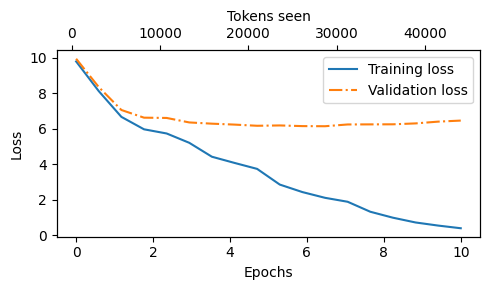

In [28]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

- 查看上面的结果，我们可以看到模型开始时生成难以理解的单词串，而在接近结束时，它能够产生语法上或多或少正确的句子
- 但是，基于训练集和验证集损失，我们可以看到模型开始过拟合
- 如果我们检查它在接近结束时写的几段文字，我们会发现它们完全包含在训练集中——它只是记住了训练数据
- 稍后，我们将介绍可以在一定程度上减轻这种记忆的解码策略
- 请注意，这里出现过拟合是因为我们有一个非常非常小的训练集，并且我们多次迭代它
  - 这里的 LLM 训练主要用于教育目的；我们主要想看到模型可以学习产生连贯的文本
  - 而不是花费数周或数月时间在大量昂贵的硬件上训练这个模型，我们稍后会加载预训练权重

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/mental-model-2.webp" width=350px>

**如果您有兴趣使用更高级的技术来增强此训练函数，例如学习率预热、余弦退火和梯度裁剪，请参阅 [附录 D](../../appendix-D/01_main-chapter-code)**

**如果您对更大的训练数据集和更长的训练运行感兴趣，请参阅 [../03_bonus_pretraining_on_gutenberg](../03_bonus_pretraining_on_gutenberg)**

## 5.3 控制随机性的解码策略

- 对于像我们上面训练的 GPT 模型这样相对较小的 LLM，推理相对便宜，所以如果您在上面使用 GPU 进行训练，则不需要使用 GPU 进行推理
- 使用我们之前在简单训练函数中使用的 `generate_text_simple` 函数（来自前一章），我们可以一次生成一个新单词（或 token）
- 如第 5.1.2 节所述，下一个生成的 token 是词汇表中所有 token 中对应最大概率分数的 token

In [29]:
model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know," was one of the axioms he laid down across the Sevres and silver of an exquisitely appointed lun


- 即使我们多次执行上面的 `generate_text_simple` 函数，LLM 也总是生成相同的输出
- 我们现在引入两个概念，即所谓的解码策略，来修改 `generate_text_simple`：*温度缩放*和*top-k*采样
- 这些将允许模型控制生成文本的随机性和多样性

### 5.3.1 温度缩放

- 以前，我们总是使用 `torch.argmax` 采样概率最高的 token 作为下一个 token
- 为了增加多样性，我们可以使用 `torch.multinomial(probs, num_samples=1)` 从概率分布中采样下一个 token
- 这里，每个索引被选中的机会对应于它在输入张量中的概率

- 这是生成下一个 token 的简要回顾，假设一个非常小的词汇表用于说明目的：

In [30]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}

# Suppose input is "every effort moves you", and the LLM
# returns the following logits for the next token:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

# The next generated token is then as follows:
print(inverse_vocab[next_token_id])

forward


In [31]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


- 不是通过 `torch.argmax` 确定最可能的 token，我们使用 `torch.multinomial(probas, num_samples=1)` 通过从 softmax 分布中采样来确定最可能的 token
- 为了说明目的，让我们看看当我们使用原始 softmax 概率采样下一个 token 1,000 次时会发生什么：

In [32]:
def print_sampled_tokens(probas):
    torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample), minlength=len(probas))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward
0 x you


- 我们可以通过称为温度缩放的概念来控制分布和选择过程
- "温度缩放"只是将 logits 除以大于 0 的数字的一个花哨说法
- 大于 1 的温度在应用 softmax 后将导致更均匀分布的 token 概率
- 小于 1 的温度在应用 softmax 后将导致更自信（更尖锐或更峰值）的分布

- 请注意，根据您的操作系统，生成的 dropout 输出可能看起来不同；您可以在 [PyTorch 问题跟踪器](https://github.com/pytorch/pytorch/issues/121595) 上阅读有关此不一致性的更多信息

In [33]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values
temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

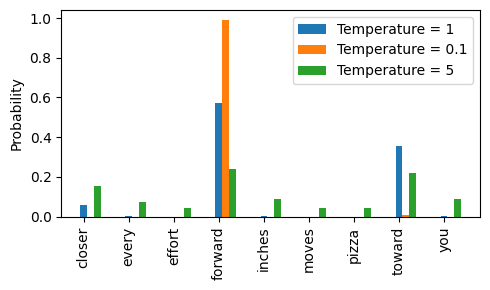

In [34]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

- 我们可以看到，通过温度 0.1 重新缩放会导致更尖锐的分布，接近 `torch.argmax`，因此几乎总是选择最可能的单词：

In [35]:
print_sampled_tokens(scaled_probas[1])

0 x closer
0 x every
0 x effort
985 x forward
0 x inches
0 x moves
0 x pizza
15 x toward
0 x you


- 通过温度 5 重新缩放的概率更均匀分布：

In [36]:
print_sampled_tokens(scaled_probas[2])

165 x closer
75 x every
42 x effort
239 x forward
71 x inches
46 x moves
32 x pizza
227 x toward
103 x you


- 假设 LLM 输入 "every effort moves you"，使用上述方法有时可能导致无意义的文本，例如 "every effort moves you pizza"，3.2% 的时间（1000 次中的 32 次）

### 5.3.2 Top-k sampling

- 为了能够使用更高的温度来增加输出多样性并减少无意义句子的概率，我们可以将采样的 token 限制为 top-k 个最可能的 token：

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/topk.webp" width=500px>

- (Please note that the numbers in this figure are truncated to two
digits after the decimal point to reduce visual clutter. The values in the Softmax row should add up to 1.0.)

- 在代码中，我们可以如下实现：

In [37]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [38]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")), 
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


> 注意：  
>
>  前一个代码单元格的替代实现（稍微更高效）如下：
>
> ```python
> new_logits = torch.full_like( # 创建包含 -inf 值的张量
>    next_token_logits, -torch.inf
>)   
> new_logits[top_pos] = next_token_logits[top_pos] # 将 top k 值复制到 -inf 张量中
> ```
> <br>
> 更多详细信息，请参阅 https://github.com/rasbt/LLMs-from-scratch/discussions/326


In [39]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


### 5.3.3 修改文本生成函数

- 前两个小节介绍了温度采样和 top-k 采样
- 让我们使用这两个概念来修改第 4 章的 `generate_text_simple` 函数，创建一个新的 `generate` 函数：

In [40]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # New (not in book): numerical stability tip to get equivalent results on mps device
            # subtract rowwise max before softmax
            logits = logits - logits.max(dim=-1, keepdim=True).values
            
            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [41]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you stand to work on surprise, a one of us had gone with random-


## 5.4 在 PyTorch 中加载和保存模型权重

- 训练大语言模型（LLM）的计算成本非常高，因此能够保存和加载LLM的权重非常重要

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/mental-model-3.webp" width=400px>

- PyTorch 中推荐的方法是通过将 `torch.save` 函数应用于 `.state_dict()` 方法来保存模型权重，即所谓的 `state_dict`：

In [42]:
torch.save(model.state_dict(), "model.pth")

- 然后我们可以将模型权重加载到新的 `GPTModel` 模型实例中，如下所示：

In [43]:
model = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("model.pth", map_location=device, weights_only=True))
model.eval();

- 使用自适应优化器（如 Adam 或 AdamW）而不是常规 SGD 来训练 LLM 很常见
- 这些自适应优化器为每个模型权重存储额外的参数，因此如果计划稍后继续预训练，保存它们也是有意义的：

In [44]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    }, 
    "model_and_optimizer.pth"
)

In [45]:
checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

## 5.5 从 OpenAI 加载预训练权重

- 以前，我们只使用一个非常小的短篇故事书来训练一个小型 GPT-2 模型，用于教育目的
- 感兴趣的读者还可以在 [../03_bonus_pretraining_on_gutenberg](../03_bonus_pretraining_on_gutenberg) 中找到在完整的 Project Gutenberg 书籍语料库上进行的更长的预训练运行
- 幸运的是，我们不必花费数万到数十万美元在大型预训练语料库上预训练模型，而是可以加载 OpenAI 提供的预训练权重

---

---


⚠️ **注意：某些用户可能在本节中遇到 TensorFlow 兼容性问题，特别是在某些 Windows 系统上。这里只需要 TensorFlow 来加载原始的 OpenAI GPT-2 权重文件，然后我们将其转换为 PyTorch。
如果您遇到 TensorFlow 相关问题，可以使用下面的替代代码，而不是本节中的其余代码。
此替代方案基于预转换的 PyTorch 权重，使用上一节中描述的相同转换过程创建。详细信息，请参阅笔记本：
[../02_alternative_weight_loading/weight-loading-pytorch.ipynb](../02_alternative_weight_loading/weight-loading-pytorch.ipynb) 笔记本。**

```python
file_name = "gpt2-small-124M.pth"
# file_name = "gpt2-medium-355M.pth"
# file_name = "gpt2-large-774M.pth"
# file_name = "gpt2-xl-1558M.pth"

url = f"https://huggingface.co/rasbt/gpt2-from-scratch-pytorch/resolve/main/{file_name}"

if not os.path.exists(file_name):
    urllib.request.urlretrieve(url, file_name)
    print(f"Downloaded to {file_name}")

gpt = GPTModel(BASE_CONFIG)
gpt.load_state_dict(torch.load(file_name, weights_only=True))
gpt.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt.to(device);


torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))
```

---

---

- 首先，一些样板代码从 OpenAI 下载文件并将权重加载到 Python 中
- 由于 OpenAI 使用了 [TensorFlow](https://www.tensorflow.org/)，我们将不得不安装并使用 TensorFlow 来加载权重；[tqdm](https://github.com/tqdm/tqdm) 是一个进度条库
- 取消注释并运行下一个单元格以安装所需的库

In [46]:
# pip install tensorflow tqdm

In [47]:
print("TensorFlow version:", version("tensorflow"))
print("tqdm version:", version("tqdm"))

TensorFlow version: 2.20.0
tqdm version: 4.67.1


In [48]:
# Relative import from the gpt_download.py contained in this folder

from gpt_download import download_and_load_gpt2
# Alternatively:
# from llms_from_scratch.ch05 import download_and_load_gpt2

2026-01-09 16:21:45.104575: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/hanj/work/llm-training/Notes-For-LLM/.venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


---

**注意**

- 在极少数情况下，上面的代码单元格可能会导致 `zsh: illegal hardware instruction python` 错误，这可能是由于您机器上的 TensorFlow 安装问题
- 一位读者发现通过 `conda` 安装 TensorFlow 解决了这个特定情况下的问题，如 [这里](https://github.com/rasbt/LLMs-from-scratch/discussions/273#discussioncomment-12367888) 所述
- 您可以在这个补充 [Python 设置教程](https://github.com/rasbt/LLMs-from-scratch/tree/main/setup/01_optional-python-setup-preferences#option-2-using-conda) 中找到更多说明

---

- 然后，我们可以如下下载 1.24 亿参数模型的模型权重：

In [49]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 37.9kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 855kiB/s] 
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 49.8kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [1:05:42<00:00, 126kiB/s]  
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 1.32MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:05<00:00, 79.4kiB/s] 
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 474kiB/s]  
2026-01-09 17:27:58.089169: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 154389504 exceeds 10% of free system memory.


In [50]:
print("Settings:", settings)

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}


In [51]:
print("Parameter dictionary keys:", params.keys())

Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [52]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


- 或者，"355M"、"774M" 和 "1558M" 也是支持的 `model_size` 参数
- 这些不同大小模型之间的差异总结在下图中：

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/gpt-sizes.webp?timestamp=123" width=500px>

- 上面，我们将 124M GPT-2 模型权重加载到 Python 中，但我们仍然需要将它们传输到我们的 `GPTModel` 实例中
- 首先，我们初始化一个新的 GPTModel 实例
- 请注意，原始 GPT 模型在多头注意力模块中为查询、键和值矩阵的线性层初始化了偏置向量，这不是必需的或推荐的；但是，为了能够正确加载权重，我们也必须通过在我们的实现中将 `qkv_bias` 设置为 `True` 来启用这些
- 我们还使用原始 GPT-2 模型使用的 `1024` token 上下文长度

In [53]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval();

- 下一个任务是将 OpenAI 权重分配给我们的 `GPTModel` 实例中相应的权重张量

In [54]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [55]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])
    
    
load_weights_into_gpt(gpt, params)
gpt.to(device);

- 如果模型加载正确，我们可以使用它通过我们之前的 `generate` 函数生成新文本：

In [56]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you toward finding an ideal new way to practice something!

What makes us want to be on top of that?




- 我们知道模型权重加载正确，因为模型可以生成连贯的文本；如果我们犯了哪怕很小的错误，模型也无法做到这一点

- 有关从 Hugging Face Hub 加载权重的替代方法，请参阅 [../02_alternative_weight_loading](../02_alternative_weight_loading)
- 如果您有兴趣了解 GPT 架构与 Llama 架构（Meta AI 开发的流行 LLM）的比较，请参阅 [../07_gpt_to_llama](../07_gpt_to_llama) 的奖励内容

## 总结和要点

- 参见 [./gpt_train.py](./gpt_train.py) 脚本，这是一个用于训练的独立脚本
- [./gpt_generate.py](./gpt_generate.py) 脚本从 OpenAI 加载预训练权重并根据提示生成文本
- 您可以在 [./exercise-solutions.ipynb](./exercise-solutions.ipynb) 中找到练习解决方案